*Vanda Balogh*

*Home Assignment Task - ML Engineer*

# Solution

In [ ]:
import os
import numpy as np
from collections import defaultdict

## 1. Load dataset

In [ ]:
from matplotlib import pyplot
from keras.datasets import cifar10
from keras.utils.np_utils import to_categorical 

170500096/170498071 [==============================] - 13s 0us/step
Train: X=(50000, 32, 32, 3), y=50000
Test: X=(10000, 32, 32, 3), y=10000


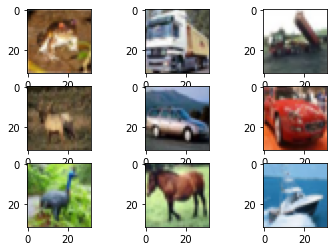

In [ ]:
(trainX, trainLabels), (testX, testLabels) = cifar10.load_data()
trainLabels = [e[0] for e in trainLabels]
testLabels = [e[0] for e in testLabels]

# normalize
trainX = trainX.astype('float32')
testX = testX.astype('float32')
trainX = trainX / 255.0
testX= testX / 255.0

cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, len(trainLabels)))
print('Test: X=%s, y=%s' % (testX.shape, len(testLabels)))
# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# plot raw pixel data
	pyplot.imshow(trainX[i])
# show the figure
pyplot.show()

### Explore dataset

Distribution of classes

In [ ]:
import matplotlib.pyplot as plt

def plot_class_distribution(labels, datasetName):
  plt.clf()
  countLabels = [labels.count(i) for i in range(len(cifar_classes))]
  plt.pie(countLabels, labels=cifar_classes, autopct='%.0f%%')
  plt.title(datasetName + " dataset class distribution", fontsize=15)
  plt.show()

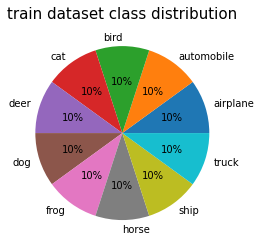

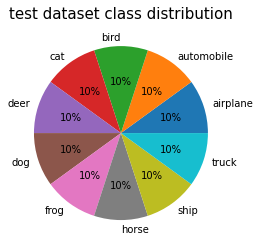

In [ ]:
plot_class_distribution(trainLabels, "train")
plot_class_distribution(testLabels, "test")

Color channels

In [ ]:
def compute_average_image_color(img):
    r_mean = np.mean(img[:,:,0])
    g_mean = np.mean(img[:,:,1])
    b_mean = np.mean(img[:,:,2])
    return (r_mean, g_mean, b_mean)
  
def compute_rgb_dominance(dataset):
  avgImgColors = [compute_average_image_color(img) for img in dataset]
  # avgImgColors = [get_dominant_color(img) for img in dataset] # too slow, heuristics needed
  rgbDominance =  [avgColor.index(max(avgColor)) for avgColor in avgImgColors]
  # countRgbDominance = [rgbDominance.count(i) for i in range(3)]
  return rgbDominance

In [ ]:
 def plot_rgb_dominance(rgbDominance, datasetName):
  # avgImgColors = [compute_average_image_color(img) for img in dataset]
  # avgImgColors = [get_dominant_color(img) for img in dataset] # too slow, heuristics needed
  # rgbDominance =  [avgColor.index(max(avgColor)) for avgColor in avgImgColors]
  countRgbDominance = [rgbDominance.count(i) for i in range(3)]
  plt.pie(countRgbDominance, labels=['R', 'G', 'B'], autopct='%.0f%%', colors=['r', 'g', 'b'])
  plt.title(datasetName + " dataset RGB distribution")
  plt.show()

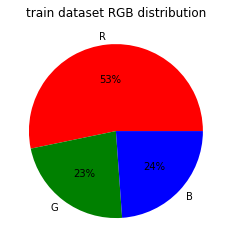

In [ ]:
trainRgbDominance = compute_rgb_dominance(trainX)
plot_rgb_dominance(trainRgbDominance, "train")

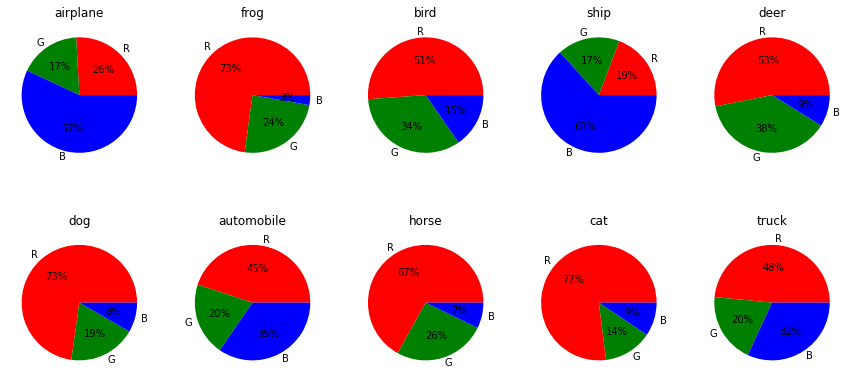

In [ ]:
import pandas as pd
train_df = pd.DataFrame(data={'class': trainLabels, 'colorDominance': trainRgbDominance}) 
groups = train_df.groupby('class').groups
figure, axes = plt.subplots(nrows=2, ncols=5,figsize=(15,7))
for c, indices in groups.items():
  classRgbDominance =  [trainRgbDominance[i] for i in indices]
  countClassRgbDominance = [classRgbDominance.count(i) for i in range(3)]
  axes[c%2, c%5].pie(countClassRgbDominance, labels=['R', 'G', 'B'], autopct='%.0f%%', colors=['r', 'g', 'b'])
  axes[c%2, c%5].title.set_text(cifar_classes[c])
figure.show()

In [ ]:
 #source https://adamspannbauer.github.io/2018/03/02/app-icon-dominant-colors/ 
from sklearn.cluster import KMeans
from collections import Counter
import cv2 #for resizing image


def get_dominant_color(image, k=4, image_processing_size = None):
    """
    takes an image as input
    returns the dominant color of the image as a list
    
    dominant color is found by running k means on the 
    pixels & returning the centroid of the largest cluster

    processing time is sped up by working with a smaller image; 
    this resizing can be done with the image_processing_size param 
    which takes a tuple of image dims as input

    >>> get_dominant_color(my_image, k=4, image_processing_size = (25, 25))
    [56.2423442, 34.0834233, 70.1234123]
    """
    #resize image if new dims provided
    if image_processing_size is not None:
        image = cv2.resize(image, image_processing_size, 
                            interpolation = cv2.INTER_AREA)
    
    #reshape the image to be a list of pixels
    image = image.reshape((image.shape[0] * image.shape[1], 3))

    #cluster and assign labels to the pixels 
    clt = KMeans(n_clusters = k)
    labels = clt.fit_predict(image)

    #count labels to find most popular
    label_counts = Counter(labels)

    #subset out most popular centroid
    dominant_color = clt.cluster_centers_[label_counts.most_common(1)[0][0]]

    return list(dominant_color)

### Select a subset of 1k training images optimal for the task

**Idea behind method:**

- choose 3 classes whose minimum color channel contribution is maximal (based on data exploration)

- chosen classes: automobile, truck, airplane

- choose ~1000/3 images from each kept class so that the dominant color channel is as balanced (equally distributed) as possible


In [ ]:
def sample_dataset(df, target_data_size=1000, divider=9):
  target_color_number = int(np.ceil(target_data_size/9))
  threeClassDf = pd.DataFrame()
  for className in ["automobile", "truck", "airplane"]:
    classDf = df[(df["class"] == cifar_classes.index(className))]
    sampled = classDf.groupby("colorDominance").sample(n=target_color_number, random_state=0)
    # sampled = classDf.sample(target_number, random_state=0)
    threeClassDf = threeClassDf.append(sampled)

  threeClassDf = threeClassDf.sample(frac = 1)
  np.random.seed(0)
  drop_indices = np.random.choice(threeClassDf.index, len(threeClassDf)-target_data_size, replace=False)
  threeClassDf = threeClassDf.drop(drop_indices)

  return threeClassDf

In [ ]:
from sklearn.model_selection import train_test_split
trainVal3ClassDf = sample_dataset(train_df, target_data_size=1500)
train3ClassDf, val3ClassDf = train_test_split(trainVal3ClassDf, train_size=1000)
print("train: ", len(train3ClassDf), "val: ", len(val3ClassDf))
train3ClassDf.head()

train:  1000 val:  500


,class,colorDominance
27862,0,1
15886,0,0
42722,0,2
45445,0,2
14101,1,0


In [ ]:
train3ClassDf.groupby("colorDominance").size()

colorDominance
0    344
1    326
2    330
dtype: int64

In [ ]:
train3ClassDf.groupby("class").size()

class
0    347
1    330
9    323
dtype: int64

In [ ]:
testRgbDominance = compute_rgb_dominance(testX)
test_df = pd.DataFrame(data={'class': testLabels, 'colorDominance': testRgbDominance}) 
test3ClassDf = sample_dataset(test_df)
test3ClassDf.head()

,class,colorDominance
4371,1,0
5109,9,0
970,9,1
7218,9,2
5027,0,0


In [ ]:
class_number = 3
def get_Xy(dataset, threeClassDf, class_number=3):
  threeClassLabels = threeClassDf["class"].unique()
  yClasses = to_categorical(np.array(threeClassDf["class"].replace(threeClassLabels, range(class_number))), num_classes=class_number)
  yDominantChannel = to_categorical(np.array(threeClassDf["colorDominance"]), num_classes=class_number)

  indices = np.array(threeClassDf.index)
  X3 = dataset[indices]
  yDominantColor = np.array([get_dominant_color(img) for img in X3])
  return X3, yClasses, yDominantChannel, yDominantColor

In [ ]:
trainX3, trainyClasses, trainyDominantChannel, trainyDominantColor = get_Xy(trainX, train3ClassDf, class_number)
valX3, valyClasses, valyDominantChannel, valyDominantColor = get_Xy(trainX, val3ClassDf, class_number)
testX3, testyClasses, testyDominantChannel, testyDominantColor = get_Xy(testX, test3ClassDf, class_number)

In [ ]:
for i in range(10):
  print(testyDominantChannel[i], testyDominantColor[i])

[1. 0. 0.] [0.54252    0.5188814  0.49261022]
[1. 0. 0.] [0.9889443 0.987256  0.9868723]
[0. 1. 0.] [0.26353696 0.3836979  0.28836098]
[0. 0. 1.] [0.37393868 0.3639404  0.39914033]
[0. 0. 1.] [0.8805078  0.89520675 0.91916007]
[0. 1. 0.] [0.40013477 0.39376387 0.34799725]
[1. 0. 0.] [0.41584006 0.36554402 0.34445214]
[0. 0. 1.] [0.98764706 0.98873514 0.9898346 ]
[0. 1. 0.] [0.6507447  0.6364835  0.59549856]
[1. 0. 0.] [0.94229424 0.9430383  0.92215306]


 ## 2. Modify neural network

### Load model

**Reason for this model:**

EfficentNet4 - sota model and it seemed like a challenge (4 is middle-ish). Also, I read the paper but haven't worked with the model itself.



In [ ]:
!pip install keras_applications
!pip install keras_efficientnets

     |████████████████████████████████| 51kB 5.0MB/s 


In [ ]:
from keras.applications import ResNet50, VGG16, MobileNetV2
from keras_efficientnets import EfficientNetB0, EfficientNetB4
backbone = EfficientNetB4(weights='imagenet',
                  include_top=False,
                  input_shape=(32, 32, 3))

71720960/71719528 [==============================] - 6s 0us/step


In [ ]:
backbone.summary()

### "Original" model for cifar classification (3 classes)

In [ ]:
from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(class_number, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_1 (Functional)    (None, 1, 1, 1792)        17673816  
_________________________________________________________________
flatten (Flatten)            (None, 1792)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               459008    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 18,133,595
Trainable params: 18,008,395
Non-trainable params: 125,200
_________________________________________________________________


### Modification

In [ ]:
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation, Dropout, Input
import tensorflow as tf
 
class ExtraOutputModel():
    def build_class_branch(self, inputs, backbone, class_number=3):
        # x = backbone(inputs)
        x = Flatten()(inputs)
        x = Dense(256)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(class_number)(x)
        x = Activation("sigmoid", name="class_output")(x)
        return x
    def build_color_branch(self, inputs, colors=3):
        x = Flatten()(inputs)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(colors)(x)
        x = Activation("sigmoid", name="color_output")(x)
        return x
    def build_model(self, backbone, width=32, height=32):
        input_shape = (height, width, 3)
        inputs = Input(shape=input_shape)
        x = backbone(inputs)
        class_branch = self.build_class_branch(x, backbone)
        color_branch = self.build_color_branch(x)
        model = Model(inputs=inputs,
                     outputs = [class_branch, color_branch],
                     name="my_net")
        return model
    
myModel = ExtraOutputModel().build_model(backbone)

In [ ]:
myModel.summary()

Model: "my_net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       (None, 1, 1, 1792)   17673816    input_4[0][0]                    
__________________________________________________________________________________________________
flatten_4 (Flatten)             (None, 1792)         0           functional_1[3][0]               
__________________________________________________________________________________________________
flatten_5 (Flatten)             (None, 1792)         0           functional_1[3][0]               
_____________________________________________________________________________________________

In [ ]:
!mkdir models
models_dir = "models/"
myModel.save(models_dir + "baseline_model", save_format="h5")

## 3. Train network

In [ ]:
from tensorflow.keras import backend as K
from keras.optimizers import Adam

init_lr = 1e-4
epochs = 100
batch_size=32
def trainNetwork(model, init_lr=1e-4, epochs=50, batch_size=32, verbose=0):
  opt = Adam(lr=init_lr, decay=init_lr / epochs)
  model.compile(optimizer=opt, 
                loss={
                    'class_output': 'categorical_crossentropy', 
                    'color_output': 'mse'},
                loss_weights={
                    'class_output': 1, 
                    'color_output': 0.1},
                metrics={
                    'class_output': 'accuracy',
                    'color_output': 'mae'
                    })
  history = model.fit(x=trainX3, 
                      y={"class_output": trainyClasses, "color_output": trainyDominantColor}, 
                      #np.array(tuple(zip(trainyClasses, trainyDominantColor))),
                      epochs=epochs,
                      batch_size=batch_size,
                      validation_data=(valX3, {"class_output": valyClasses, "color_output": valyDominantColor}),
                      verbose=verbose)
  return history

In [ ]:
history = trainNetwork(myModel, verbose=1)

Epoch 1/50
32/32 [==============================] - 5s 152ms/step - loss: 0.0193 - class_output_loss: 0.0124 - color_output_loss: 0.0693 - class_output_accuracy: 0.9970 - color_output_mae: 0.2056 - val_loss: 0.7709 - val_class_output_loss: 0.7654 - val_color_output_loss: 0.0550 - val_class_output_accuracy: 0.8140 - val_color_output_mae: 0.1919
Epoch 2/50
32/32 [==============================] - 3s 87ms/step - loss: 0.0394 - class_output_loss: 0.0328 - color_output_loss: 0.0657 - class_output_accuracy: 0.9960 - color_output_mae: 0.1998 - val_loss: 0.7638 - val_class_output_loss: 0.7583 - val_color_output_loss: 0.0549 - val_class_output_accuracy: 0.8200 - val_color_output_mae: 0.1900
Epoch 3/50
32/32 [==============================] - 3s 88ms/step - loss: 0.0214 - class_output_loss: 0.0146 - color_output_loss: 0.0675 - class_output_accuracy: 0.9970 - color_output_mae: 0.2018 - val_loss: 0.7719 - val_class_output_loss: 0.7663 - val_color_output_loss: 0.0556 - val_class_output_accuracy: 0.

In [ ]:
!mkdir results
!mkdir results/history
history_dir = 'results/history/'
def save_history(history, name):
  with open(history_dir + name +'_history.json', mode='w') as f:
      pd.DataFrame(history.history).to_json(f)

save_history(history, 'baseline')

mkdir: cannot create directory ‘results’: File exists
mkdir: cannot create directory ‘results/history’: File exists


### Evaluation (during training and after the training is completed)

**Describe evalutaion:**
- using validation data and comparing losses to training data to survey generalization ability
- losses: 
  - categorical cross entropy for cifar classes since its a classification problem
  - mean squared error for color dominance since values are continous and it can be modeled as a regression problem (wrt each color channel). MSE (L2 loss) penalizes large errors more than MAE (L1 loss)
- metrics:
  - cifar classes: accuracy, classification report since its a classification task
  - color dominance: 
    - mean absolute error to get an overall picture of absolute losses
    - classification report: from previous experiments on data dominant color channels were extracted which brings the idea to model the task as a classification - which channel is the most dominant/has the highest values (based on dominant color) 


In [ ]:
print(history.history.keys(), len(history.history.keys()))
!mkdir results/plots
plots_dir = 'results/plots/'
# summarize history for accuracy
def plot_results(history, net_name='baseline'):
  losses = ['class_output_loss', 'color_output_loss', 'loss']
  metrics = ['class_output_accuracy', 'color_output_mae']
  fig, ax =plt.subplots(nrows=1, ncols=len(losses),figsize=(20,5))
  for l in losses:
    ax[losses.index(l)].semilogy(history.history[l])
    ax[losses.index(l)].semilogy(history.history['val_'+l])
    ax[losses.index(l)].title.set_text(l)
    ax[losses.index(l)].axes.set_ylabel(l)
    ax[losses.index(l)].axes.set_xlabel('epoch')
    ax[losses.index(l)].legend(['train', 'val'], loc='lower left')
  fig.suptitle(net_name + ' losses', fontsize=16)
  fig.show()
  fig.savefig(plots_dir + net_name + '_losses.pdf')
  
  fig, ax =plt.subplots(nrows=1, ncols=len(metrics),figsize=(13,6.5))
  for m in metrics:
    ax[metrics.index(m)].plot(history.history[m])
    ax[metrics.index(m)].plot(history.history['val_'+m])
    ax[metrics.index(m)].title.set_text(m)
    ax[metrics.index(m)].axes.set_ylabel(m)
    ax[metrics.index(m)].axes.set_xlabel('epoch')
    ax[metrics.index(m)].legend(['train', 'val'], loc='lower left')
  fig.suptitle(net_name + ' metrics', fontsize=16)  
  fig.show()
  fig.savefig(plots_dir + net_name + '_metrics.pdf')

dict_keys(['loss', 'class_output_loss', 'color_output_loss', 'class_output_accuracy', 'color_output_mae', 'val_loss', 'val_class_output_loss', 'val_color_output_loss', 'val_class_output_accuracy', 'val_color_output_mae']) 10
mkdir: cannot create directory ‘results’: File exists


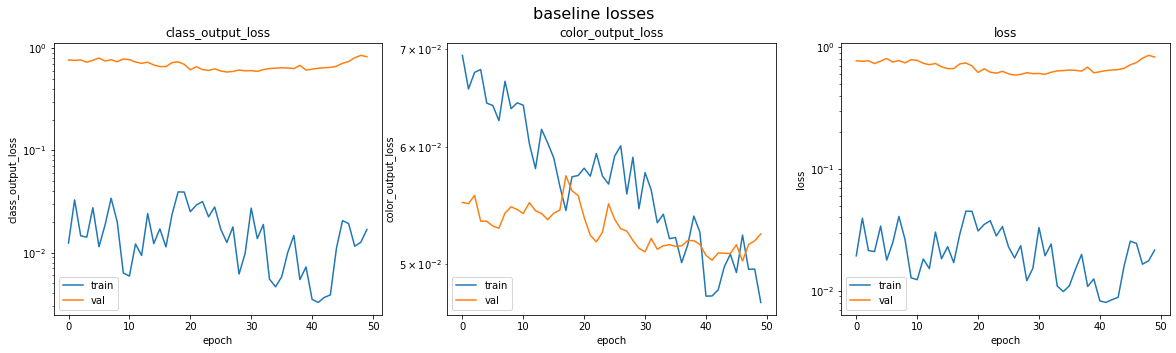

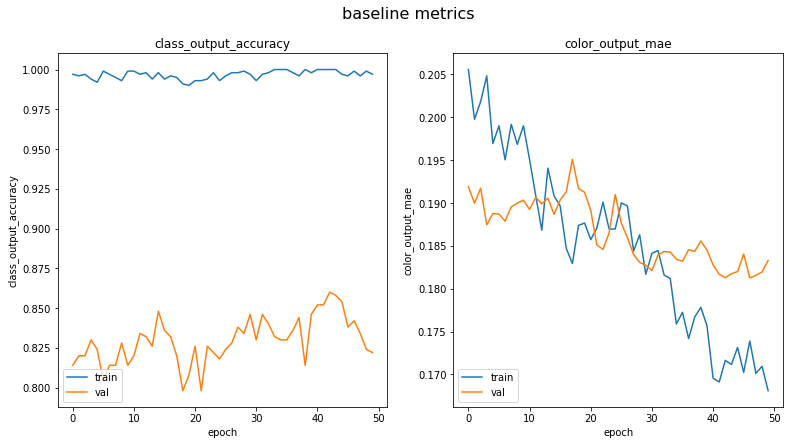

In [ ]:
plot_results(history, "baseline")

In [ ]:
from sklearn.metrics import classification_report
!mkdir results/cr_reports
cr_rports_dir = 'results/cr_reports/'
def print_classification_report(model, X3, yclasses, ycolor, model_name):
  classes_pred, colors_pred = model.predict(X3)
  classes_pred = [np.argmax(e) for e in classes_pred]
  classes_true = [np.argmax(e) for e in yclasses]
  colors_pred = [np.argmax(e) for e in colors_pred]
  colors_true = [np.argmax(e) for e in ycolor]
  cr_classes = classification_report(classes_pred, classes_true)
  classification_report_csv(cr_classes, cr_rports_dir + model_name+'_classes')
  print('class')
  for r in cr_classes.split('\n'):
    print(r)
  print('colors')
  cr_colors = classification_report(colors_pred, colors_true)
  classification_report_csv(cr_colors, cr_rports_dir + model_name+'_colors')
  for r in cr_colors.split('\n'):
    print(r)

def classification_report_csv(report, name):
    report_data = []
    lines = report.split('\n')
    for line in lines[2:5]:
        row = {}
        row_data = line.split()
        row['class'] = row_data[0]
        row['precision'] = float(row_data[1])
        row['recall'] = float(row_data[2])
        row['f1_score'] = float(row_data[3])
        row['support'] = float(row_data[4])
        report_data.append(row)
    dataframe = pd.DataFrame.from_dict(report_data)
    dataframe.to_csv(name + '_classification_report.csv', index = False)

def save_classification_reports(model, name):
  print('TRAIN')
  print_classification_report(model, trainX3, trainyClasses, trainyDominantColor, name + '_train')
  print('TEST')
  print_classification_report(model, testX3, testyClasses, testyDominantColor,name + '_test')

save_classification_reports(myModel, 'baseline')

mkdir: cannot create directory ‘results’: File exists
mkdir: cannot create directory ‘results/cr_reports’: File exists
TRAIN
class
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       347
           1       1.00      1.00      1.00       330
           2       1.00      1.00      1.00       323

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000

colors
              precision    recall  f1-score   support

           0       0.42      0.50      0.46       279
           1       0.45      0.39      0.42       337
           2       0.54      0.52      0.53       384

    accuracy                           0.47      1000
   macro avg       0.47      0.47      0.47      1000
weighted avg       0.47      0.47      0.47      1000

TEST
class
              precision    recall  f1-score   support

           0       0.08      0.08 

### Methods for optimization

#### a) change backbone to be more lightweight

##### EfficientNetB0

In [ ]:
backbone_EfficientNetB0  = EfficientNetB0(weights='imagenet',
                  include_top=False,
                  input_shape=(32, 32, 3))
myModel_EfficientNetB0 = ExtraOutputModel().build_model(backbone_EfficientNetB0)
myModel_EfficientNetB0.save(models_dir + "EfficientNetB0", save_format="h5")
history_EfficientNetB0 = trainNetwork(myModel_EfficientNetB0)

with open('history_EfficientNetB0 .json', mode='w') as f:
    pd.DataFrame(history_EfficientNetB0.history).to_json(f)

TRAIN
class
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       347
           1       1.00      1.00      1.00       330
           2       1.00      1.00      1.00       323

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000

colors
              precision    recall  f1-score   support

           0       0.41      0.48      0.44       281
           1       0.42      0.37      0.39       335
           2       0.52      0.50      0.51       384

    accuracy                           0.45      1000
   macro avg       0.45      0.45      0.45      1000
weighted avg       0.45      0.45      0.45      1000

TEST
class
              precision    recall  f1-score   support

           0       0.13      0.12      0.12       376
           1       0.73      0.76      0.74       320
           2       0.06      0.07      0.06  

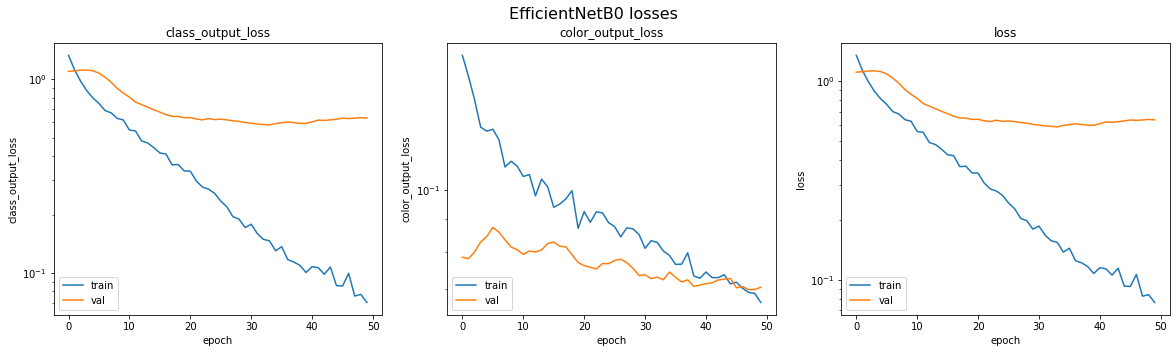

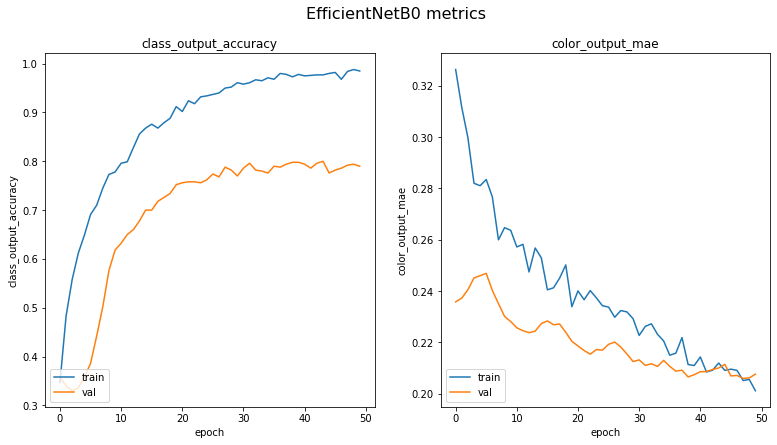

In [ ]:
plot_results(history_EfficientNetB0, 'EfficientNetB0')
save_classification_reports(myModel_EfficientNetB0, 'EfficientNetB0')
save_history(history_EfficientNetB0, 'EfficientNetB0')

##### ResNet50

In [ ]:
backbone_ResNet50  = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(32, 32, 3))
myModel_ResNet50 = ExtraOutputModel().build_model(backbone_ResNet50)
myModel_ResNet50.save(models_dir + "ResNet50", save_format="h5")
history_ResNet50 = trainNetwork(myModel_ResNet50)

94773248/94765736 [==============================] - 0s 0us/step


TRAIN
class
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       347
           1       1.00      1.00      1.00       330
           2       1.00      1.00      1.00       323

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000

colors
              precision    recall  f1-score   support

           0       0.49      0.48      0.48       335
           1       0.41      0.41      0.41       297
           2       0.54      0.55      0.54       368

    accuracy                           0.48      1000
   macro avg       0.48      0.48      0.48      1000
weighted avg       0.48      0.48      0.48      1000

TEST
class
              precision    recall  f1-score   support

           0       0.08      0.08      0.08       329
           1       0.78      0.77      0.77       338
           2       0.08      0.08      0.08  

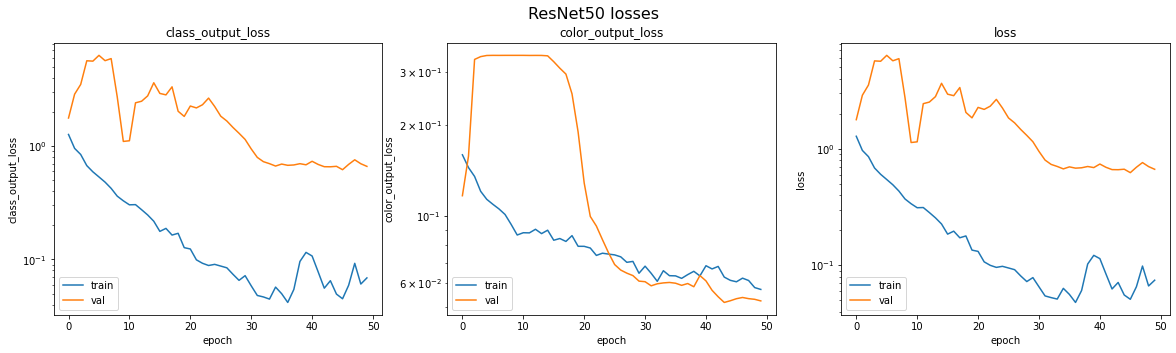

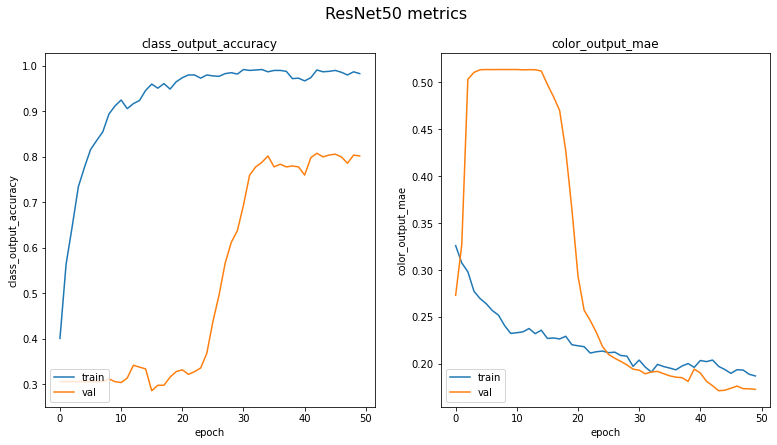

In [ ]:
plot_results(history_ResNet50, 'ResNet50')
save_classification_reports(myModel_ResNet50, 'ResNet50')
save_history(history_ResNet50, 'ResNet50')

##### MobileNetV2

In [ ]:
backbone_MobileNetV2  = MobileNetV2(weights='imagenet',
                  include_top=False,
                  input_shape=(32, 32, 3))
myModel_MobileNetV2 = ExtraOutputModel().build_model(backbone_MobileNetV2)
myModel_MobileNetV2.save(models_dir + "MobileNetV2", save_format="h5")
history_MobileNetV2 = trainNetwork(myModel_MobileNetV2)

9412608/9406464 [==============================] - 1s 0us/step


TRAIN
class
              precision    recall  f1-score   support

           0       0.99      0.45      0.62       762
           1       0.21      0.95      0.34        73
           2       0.44      0.85      0.58       165

    accuracy                           0.56      1000
   macro avg       0.55      0.75      0.51      1000
weighted avg       0.84      0.56      0.59      1000

colors
              precision    recall  f1-score   support

           0       0.02      0.44      0.05        18
           1       0.90      0.30      0.45       885
           2       0.11      0.43      0.18        97

    accuracy                           0.32      1000
   macro avg       0.35      0.39      0.23      1000
weighted avg       0.81      0.32      0.42      1000

TEST
class
              precision    recall  f1-score   support

           0       0.63      0.26      0.37       797
           1       0.16      0.93      0.27        57
           2       0.03      0.06      0.04  

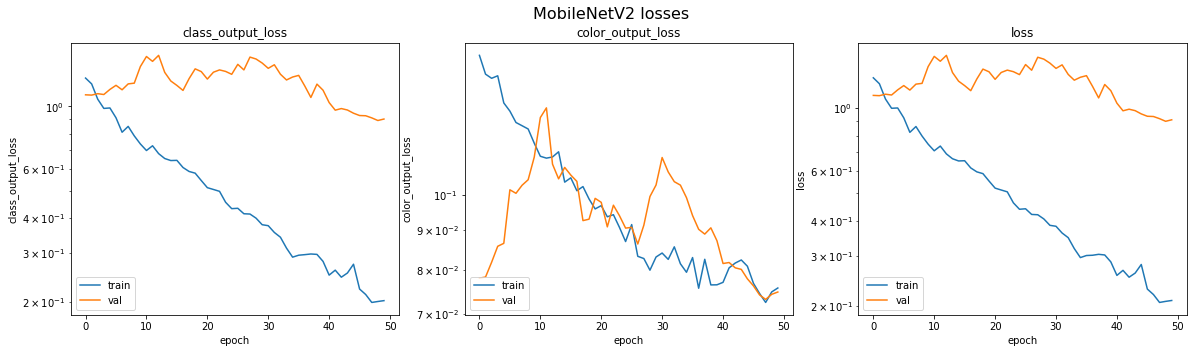

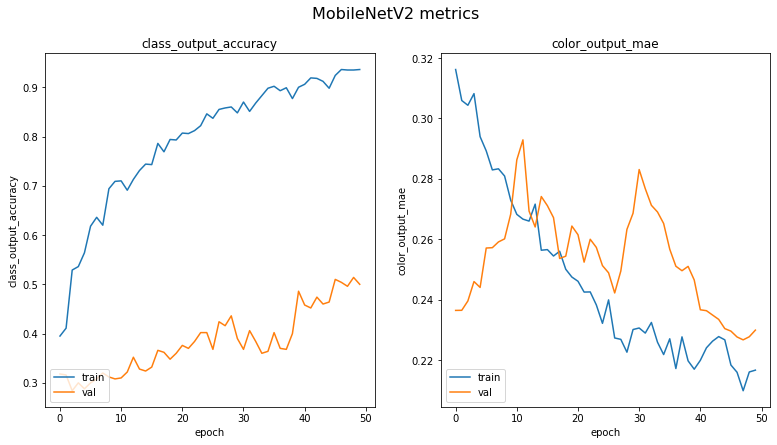

In [ ]:
plot_results(history_MobileNetV2, 'MobileNetV2')
save_classification_reports(myModel_MobileNetV2, 'MobileNetV2')
save_history(history_MobileNetV2, 'MobileNetV2')

##### Conclusion

- smaller models seem to help
- more epochs are needed though
- int he following use efficientnetb0

#### b) batchSize

In [ ]:
batch_size_list = [4,16,32,64]
batch_size_histories = {}
for batch_size in batch_size_list:
  print(batch_size)
  history_EfficientNetB0 = trainNetwork(myModel_EfficientNetB0, batch_size=batch_size, verbose=1)
  batch_size_histories[batch_size] = history_EfficientNetB0

4
Epoch 1/50
250/250 [==============================] - 11s 43ms/step - loss: 0.8222 - class_output_loss: 0.8131 - color_output_loss: 0.0910 - class_output_accuracy: 0.7000 - color_output_mae: 0.2387 - val_loss: 1.4984 - val_class_output_loss: 1.4907 - val_color_output_loss: 0.0766 - val_class_output_accuracy: 0.3060 - val_color_output_mae: 0.2360
Epoch 2/50
250/250 [==============================] - 10s 38ms/step - loss: 0.8409 - class_output_loss: 0.8323 - color_output_loss: 0.0866 - class_output_accuracy: 0.6580 - color_output_mae: 0.2355 - val_loss: 1.4736 - val_class_output_loss: 1.4659 - val_color_output_loss: 0.0767 - val_class_output_accuracy: 0.3060 - val_color_output_mae: 0.2357
Epoch 3/50
250/250 [==============================] - 10s 39ms/step - loss: 0.7918 - class_output_loss: 0.7834 - color_output_loss: 0.0835 - class_output_accuracy: 0.6930 - color_output_mae: 0.2316 - val_loss: 1.4390 - val_class_output_loss: 1.4314 - val_color_output_loss: 0.0766 - val_class_output_ac

In [ ]:
!mkdir results/batch_size
batch_size_dir = 'results/batch_size/'
def plot_misc_results(history_dict, net_name, out_dir):
  metrics = ['class_output_accuracy', 'color_output_mae']
  losses = ['class_output_loss', 'color_output_loss', 'loss']

  fig, ax =plt.subplots(nrows=1, ncols=len(losses),figsize=(20,5))
  for l in losses:
    for key, history in history_dict.items():
      ax[losses.index(l)].semilogy(history.history['val_'+l])
    ax[losses.index(l)].title.set_text(l)
    ax[losses.index(l)].axes.set_ylabel(l)
    ax[losses.index(l)].axes.set_xlabel('epoch')
    ax[losses.index(l)].legend(list(history_dict.keys()), loc='lower left')
  fig.suptitle(net_name + ' losses', fontsize=16)
  fig.show()
  fig.savefig(out_dir + net_name + '_losses.pdf')

  fig, ax =plt.subplots(nrows=1, ncols=len(metrics),figsize=(13,6.5))
  for m in metrics:
    for key, history in history_dict.items():
      ax[metrics.index(m)].semilogy(history.history['val_'+m])

    ax[metrics.index(m)].title.set_text(m)
    ax[metrics.index(m)].axes.set_ylabel(m)
    ax[metrics.index(m)].axes.set_xlabel('epoch')
    ax[metrics.index(m)].legend(list(history_dict.keys()), loc='lower left')

  fig.suptitle(net_name + ' metrics', fontsize=16)
  fig.show()
  fig.savefig(out_dir + net_name + '_metrics.pdf')

mkdir: cannot create directory ‘results/batch_size’: File exists


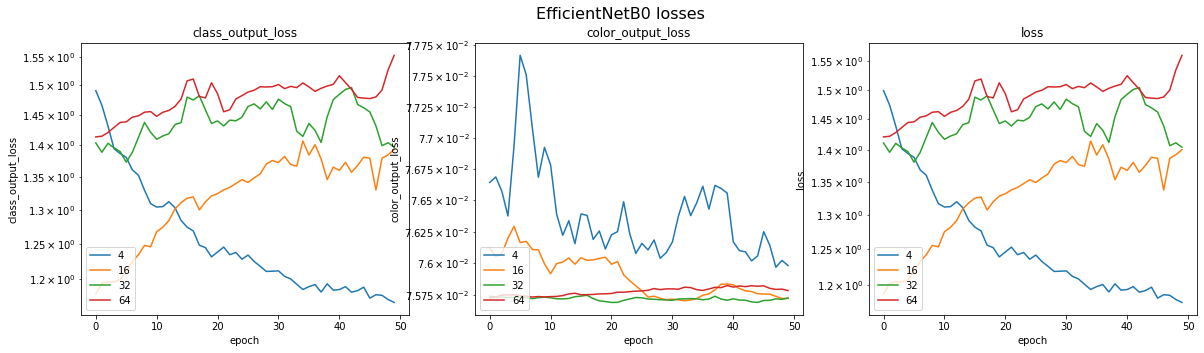

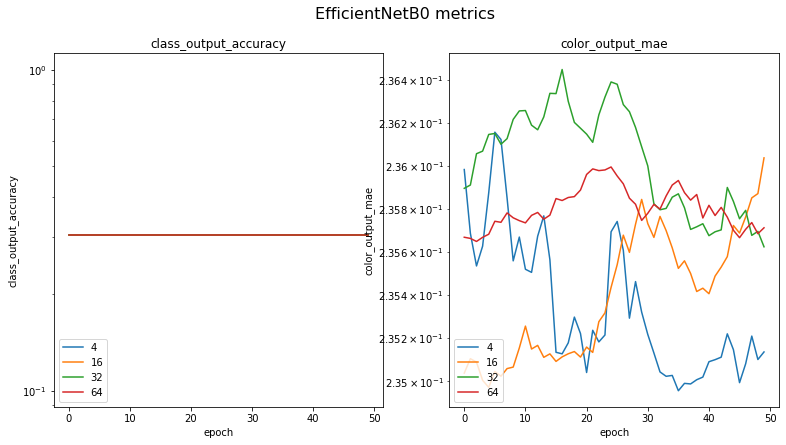

In [ ]:
plot_misc_results(batch_size_histories, 'EfficientNetB0', batch_size_dir)

##### Conclusion

smaller batch size helps (at least for 1k training images)

#### c) learning rate

In [ ]:
!mkdir results/learning_rate
learning_rate_dir = 'results/learning_rate/'
learning_rate_list = [1e-2, 1e-3, 1e-4, 1e-5]
learning_rate_histories = {}
for learning_rate in learning_rate_list:
  print(learning_rate)
  history_EfficientNetB0 = trainNetwork(myModel_EfficientNetB0, init_lr=learning_rate, verbose=1)
  learning_rate_histories[learning_rate] = history_EfficientNetB0

mkdir: cannot create directory ‘results/learning_rate’: File exists
0.01
Epoch 1/50
32/32 [==============================] - 2s 75ms/step - loss: 1.5095 - class_output_loss: 1.5022 - color_output_loss: 0.0725 - class_output_accuracy: 0.4530 - color_output_mae: 0.2227 - val_loss: 1.2624 - val_class_output_loss: 1.2539 - val_color_output_loss: 0.0852 - val_class_output_accuracy: 0.3060 - val_color_output_mae: 0.2409
Epoch 2/50
32/32 [==============================] - 1s 39ms/step - loss: 1.1056 - class_output_loss: 1.0980 - color_output_loss: 0.0758 - class_output_accuracy: 0.4820 - color_output_mae: 0.2248 - val_loss: 1.6384 - val_class_output_loss: 1.6262 - val_color_output_loss: 0.1219 - val_class_output_accuracy: 0.3060 - val_color_output_mae: 0.2944
Epoch 3/50
32/32 [==============================] - 1s 39ms/step - loss: 0.9139 - class_output_loss: 0.9059 - color_output_loss: 0.0796 - class_output_accuracy: 0.5480 - color_output_mae: 0.2296 - val_loss: 1.5568 - val_class_output_loss

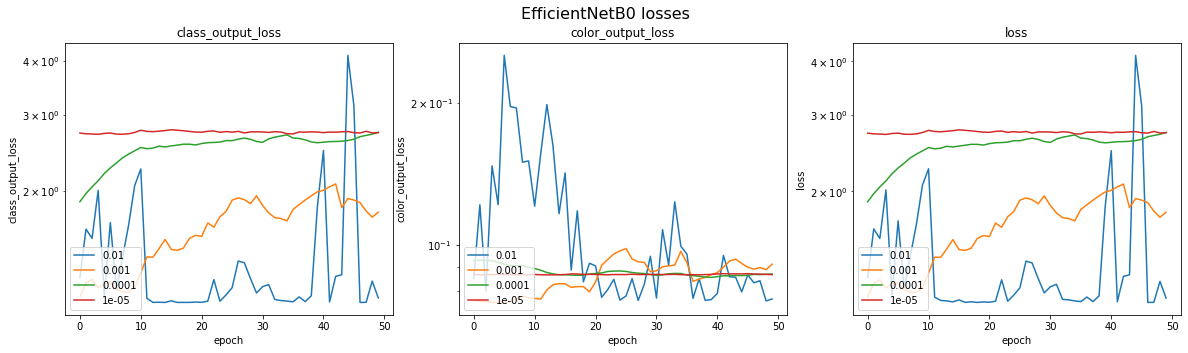

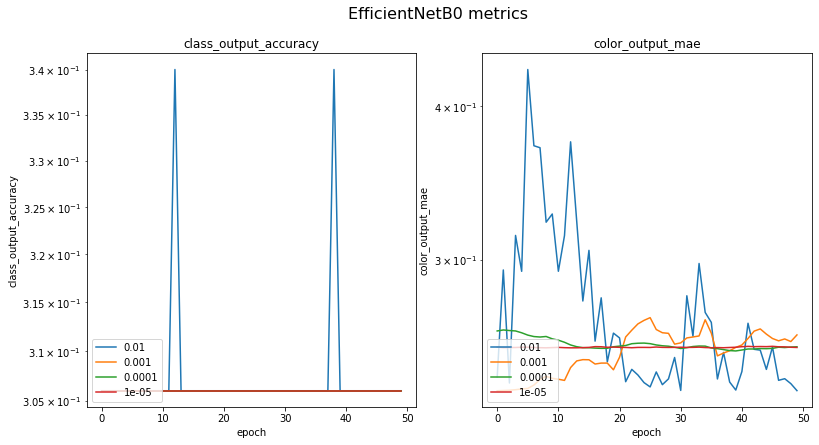

In [ ]:
plot_misc_results(learning_rate_histories, 'EfficientNetB0', learning_rate_dir)

##### Conclusion

more investigation is needed (tuning decay)

### Description of further optimization steps 

- weight regularization (L2) -> inject into backbone
- inject Dropout layers to backbone
- optimize weights of two losses




## 4. Describe the next steps...

- due to overfitting more data or data augmentation is needed => use more data and augmentation (do not use augmentation that interferes with color)
- use regularization techniques (eg label smoothing)
- optimize based on further optimization steps

## 5. How would you efficiently deploy your model

- first I would make sure (via more experiments) whether adding the new task (dominant color detection) actually helps the original classification task
- multi-task learning can help generalization on the tasks (https://arxiv.org/pdf/1707.08114.pdf), so my main point in favor pf dominant color detection next to classification is that it might help the original classification task
